In [2]:
@interact_manual

def dataoptions(
    
    nodes = widgets.SelectMultiple(options= nodeIds,value=['All'],description='Node_id(s): ', disabled=False, layout=Layout(margin='0px 0px 40px 200px')),

    start_date=widgets.DatePicker(value=pd.to_datetime('2020-06-24'),description='Starting Date', layout=Layout(margin='0px 0px 0px 0px')),                      
    end_date=widgets.DatePicker(value=pd.to_datetime('2020-11-01 23:00:00'),description='Ending Date', layout=Layout(margin='-30px 0px 0px 400px')),
                           
    tuntivalitsin=widgets.SelectionRangeSlider(options=OptHours,index=[0,14],
    description='Tunnit',disabled=False,value=[8,22], layout=Layout(margin='20px 0px 0px 0px')),

   ):
   
    
    def getdata():
        
        global df
        import mysql.connector
        mydb = mysql.connector.connect(
        host="172.28.200.50",
       user="root",
        port=3306,
      passwd="insert-password-here",
        database="iiwari_org")
        
        mycursor = mydb.cursor(dictionary=True)
        
        # Paivmaarat string formaattiin
        start_date_string = "'{}'".format(str(start_date))
        end_date_string = "'{}'".format(str(end_date))
        
        
        # Sql kysely vaihtoehdot jos valittu 'All'
        if nodes[0] == 'All':
            mycursor.execute("SELECT * FROM CleanSensorData WHERE timestamp >= {} and timestamp < {}".format(start_date_string, end_date_string))
            
        # Jos vain 1 node valittu
        elif len(nodes) == 1:
            mycursor.execute("SELECT * FROM CleanSensorData WHERE node_id={} and timestamp >= {} and timestamp < {}".format(nodes[0], start_date_string, end_date_string))
        
        # Monta nodea valittuna
        else:
            mycursor.execute("SELECT * FROM CleanSensorData WHERE node_id IN {} and timestamp >= {} and timestamp < {}".format(nodes, start_date_string, end_date_string))
            
        df = pd.DataFrame(mycursor.fetchall())
        
        # Palauttaa virheilmoituksen jos dataframe on tyhja
        if len(df) == 0:
            return print("Error 01: Empty Dataset ")
        
        
        # Timestamp datetime muotoon
        df['timestamp'] = df['timestamp'].astype(str)
        df['timestamp'] = df['timestamp'].str.slice(2, -2)
        df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
        
        # Sorttaa tunnit                   
        df = df.loc[df.timestamp.dt.strftime('%-H').astype('int32') >= tuntivalitsin[0]]
        df = df.loc[df.timestamp.dt.strftime('%-H').astype('int32') <= tuntivalitsin[1]]
        
        return df
    
    df = getdata()
   
    # Haetaan valittu kuvaaja, widgeteiltä saatujen arvojen perusteella #
    return df

interactive(children=(SelectMultiple(description='Node_id(s): ', index=(0,), layout=Layout(margin='0px 0px 40p…

In [1]:
import sys
import pandas as pd
import time
import timeit
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets


# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from clean_velocities import *
from draw_node_amount import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from reittien_erottelu import *
from isolation_forest import *
from sisään_uloskäynnit import *
from horrostila import *
from widgets import *
from plot_lapimenoajat import *

'''def timing():
    start_time = timeit.default_timer()
    #start_time = time.time()
    #return lambda x: print("{} {:.3f}s".format(x, time.time() - start_time))
    y = '{:.10f}s #'.format(timeit.default_timer() - start_time)
    return lambda x: print(f"\n#{len(y+x)*'='}#\n# {x}{y}\n#{len(y+x)*'='}#\n")
t = timing()
t("Execution time: ")'''
# tai from ... import *

'def timing():\n    start_time = timeit.default_timer()\n    #start_time = time.time()\n    #return lambda x: print("{} {:.3f}s".format(x, time.time() - start_time))\n    y = \'{:.10f}s #\'.format(timeit.default_timer() - start_time)\n    return lambda x: print(f"\n#{len(y+x)*\'=\'}#\n# {x}{y}\n#{len(y+x)*\'=\'}#\n")\nt = timing()\nt("Execution time: ")'

# Database query

In [2]:
df = database_query("SELECT * FROM SensorData limit 50000")
df.head()

node_id                            timestamp     x    y  \
0  b'-2393099149039893833'  b'2020-06-24 12:20:08.533016+00:00'  2762 -257   
1  b'-2393099149039893833'  b'2020-06-24 12:20:08.620015+00:00'  2870 -344   
2  b'-2393099149039893833'  b'2020-06-24 12:20:09.622827+00:00'  2916 -344   
3  b'-2393099149039893833'  b'2020-06-24 12:20:09.622846+00:00'  2894 -254   
4  b'-2393099149039893833'  b'2020-06-24 12:20:10.116102+00:00'  2888 -188   

     z  q  
0  100  0  
1  100  0  
2  100  0  
3  100  0  
4  100  0

# Histogram of x and y coordinates

x mean:  1959.85514
y mean:  570.94314
x std:  878.0638038978605
y std:  1028.422147713156


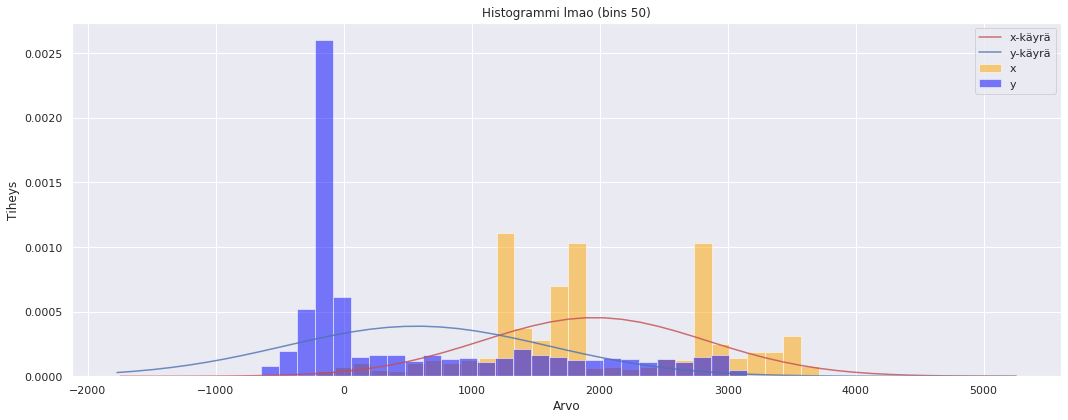

CPU times: user 2.32 s, sys: 100 ms, total: 2.42 s
Wall time: 1.01 s


In [3]:
%%time
draw_histogram(df['x'], df['y'], 50)

# Find outliers using z_score

Number of missing variables in table
 node_id      0
timestamp    0
x            0
y            0
z            0
q            0
dtype: int64
------------------------------
Unique values in columns

uniques in node_id: 1
uniques in timestamp: 50000
uniques in x: 3923
uniques in y: 3955
uniques in z: 1
uniques in q: 1
------------------------------
Checking z and q columns

uniques in z [100]
uniques in q [0]
------------------------------
Number of nodes: 1
------------------------------
Outliers

Data with outliers:  50000
Ouliers removed:     148
Data after:          49852
Percent removed:    0.3 %
Percent remaining:  99.7 %
------------------------------
CPU times: user 398 ms, sys: 8.15 ms, total: 406 ms
Wall time: 404 ms


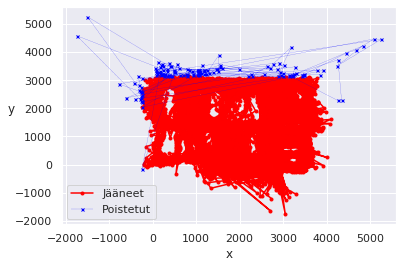

In [4]:
%%time
df1 = find_outliers(df)

Koko datasetissä (13 890 906)
- Data with outliers: 13 890 906
- Ouliers removed:    376 791
- Data after:         13 514 115

In [5]:
def clean_dataframe(df):
    
    # node_id:s to 1-32 format
    df['node_id'] = pd.factorize(df['node_id'])[0] + 1
    
    # Timestamp to datetime
    df['timestamp'] = df['timestamp'].astype(str)
    df['timestamp'] = df['timestamp'].str.slice(2, -7)
    df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
    
    # Round ms
    df.timestamp = df.timestamp.dt.round("ms")
    df.timestamp = df.timestamp.dt.tz_localize('UTC')

    # Muunnetaan Suomen aikaan. Tämä huomioi kesä- ja talviajan.
    df.timestamp = df.timestamp.dt.tz_convert('Europe/Helsinki')
    
    # Drop +00 ending
    df['timestamp'] = df['timestamp'].astype(str)
    df['timestamp'] = df['timestamp'].str.slice(0, -7)
    df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
    
    # viikonpäiväkolumni
    df['dayofweek'] = df.timestamp.dt.dayofweek
    
    print(df.timestamp.dt.hour.unique())
    print(f"{'-'*30}\nFiltering out after-hours\n")
    print("Data before filtering: ", len(df))
    print("Deleted nodes before 8:00: ",len(df) - len(df.drop(df[(df.timestamp.dt.hour < 8)].index)))
    print("Deleted nodes after 21:00: ", len(df) - len(df.drop(df[(df.timestamp.dt.hour > 21)].index)))
    print("Deleted after-hours nodes: ", (len(df.drop(df[(df.timestamp.dt.hour < 8)].index)) + len(df.drop(df[(df.timestamp.dt.hour > 21)].index))))
    # Poistetaan aukioloaikojen ulkopuolella olevat ajat
    df = df.drop(df[(df.timestamp.dt.hour < 8)].index) #dropataan kaikki 8-21 ulkopuolella olevat tunnit
    df = df.drop(df[(df.timestamp.dt.hour > 21)].index)
    df = df.reset_index(drop=True) # resetoidaan indexit, että voidaan ajaa uudet koodit
    
    # alustetaan uusi kolumni nollalla, tähän tulee kyseinen tunti kaupassa, esimerkiksi klo 8 eli aukioloajan ensimmäinen tunti on 1
    df['current_hour'] = 0
    
    # Käydään läpi timestamp ja jokaikisen tunnin kohdalle lisätään yksi tunti. Aloitetaan tunnista 8
    #Koska 8-21 välillä 15 tuntia, ajetaan tämä 15 kertaa
    for i in range(15):
        df['current_hour'].loc[df['timestamp'].dt.hour == 8+i] = i+1

    #Sunnuntaina aloitetaan kaksi tuntia myöhemmin, joten vähennetään kaksi tuntia jokaisesta hetkestä
    df['current_hour'].loc[df['timestamp'].dt.dayofweek == 6] = df['current_hour'].loc[df['timestamp'].dt.dayofweek == 6] - 2
    
    # Suodatetaan Sunnuntaitten aukioloajat
    df_temp = df[df.timestamp.dt.dayofweek == 6].index.values.tolist()
    df_new_temp = df.iloc[df_temp][df.iloc[df_temp].timestamp.dt.hour < 10]

    # Poistetaan alkuperäisestä dataframesta kyseiset arvot
    df = df.drop(df.index[df_new_temp.index.values])
    
    df = df.reset_index(drop=True)
    
    # Drop z and q columns
    df = df.drop(columns=['z','q'])
    
    bad_nodes = [13,14,18,27,32]
    
    # Poistetaan huonot nodet
    print(f"{'-'*30}\nBad nodes: {bad_nodes}\n")
    print("Amount of bad nodes", (len(df[df.node_id == 13]) + len(df[df.node_id == 14]) + len(df[df.node_id == 18]) + len(df[df.node_id == 27]) + len(df[df.node_id == 32])))
    print("Data after deleting bad nodes: ", len(df) - (len(df[df.node_id == 13]) + len(df[df.node_id == 14]) + len(df[df.node_id == 18]) + len(df[df.node_id == 27]) + len(df[df.node_id == 32])))
    print(f"{'-'*30}")
    df = df[df.node_id != 13]
    df = df[df.node_id != 14]
    df = df[df.node_id != 18]
    df = df[df.node_id != 27]
    df = df[df.node_id != 32]
    
    return df

clean_dataframe(df1)

[15  7  8  9 10 11 12 13 16 17 18 19 20 14  6 21  5]
------------------------------
Filtering out after-hours

Data before filtering:  49852
Deleted nodes before 8:00:  2324
Deleted nodes after 21:00:  0
Deleted after-hours nodes:  97380
------------------------------
Bad nodes: [13, 14, 18, 27, 32]

Amount of bad nodes 0
Data after deleting bad nodes:  47528
------------------------------


node_id               timestamp     x    y  dayofweek  current_hour
0            1 2020-06-24 15:20:08.533  2762 -257          2             8
1            1 2020-06-24 15:20:08.620  2870 -344          2             8
2            1 2020-06-24 15:20:09.623  2916 -344          2             8
3            1 2020-06-24 15:20:09.623  2894 -254          2             8
4            1 2020-06-24 15:20:10.116  2888 -188          2             8
...        ...                     ...   ...  ...        ...           ...
47523        1 2020-07-07 16:36:08.795  1277  -71          1             9
47524        1 2020-07-07 16:36:18.795  1278  -77          1             9
47525        1 2020-07-07 16:36:27.795  1277  -80          1             9
47526        1 2020-07-07 16:36:38.793  1273  -85          1             9
47527        1 2020-07-07 16:36:47.793  1272  -86          1             9

[47528 rows x 6 columns]

# Cleaning Node_id, timestamp, q, z columns

In [9]:
df1 = clean_dataframe(df1)
df1

node_id               timestamp     x    y  dayofweek  current_hour
0           1 2020-06-24 15:20:08.533  2762 -257          2             8
1           1 2020-06-24 15:20:08.620  2870 -344          2             8
2           1 2020-06-24 15:20:09.623  2916 -344          2             8
3           1 2020-06-24 15:20:09.623  2894 -254          2             8
4           1 2020-06-24 15:20:10.116  2888 -188          2             8
...       ...                     ...   ...  ...        ...           ...
9623        1 2020-06-29 13:19:16.418  1301 -120          0             6
9624        1 2020-06-29 13:19:25.418  1301 -119          0             6
9625        1 2020-06-29 13:19:35.418  1305 -112          0             6
9626        1 2020-06-29 13:19:45.418  1305 -112          0             6
9627        1 2020-06-29 13:19:54.418  1307 -112          0             6

[9628 rows x 6 columns]

# Katsotaan kuinka paljon kutakin nodea on käytetty

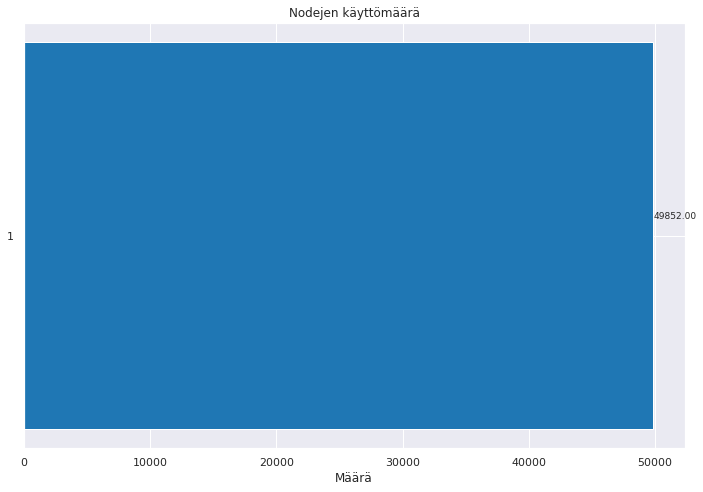

In [6]:
draw_node_amount(df1, 'node_id')

# Tehdään uuten tiedostoon Isolation Forestilla putsatut nodet

Dataframe lenght before: 49852
Dataframe lenght after: 49702
Total outliers detected: 150
Percent removed:    0.3 %
Percent remaining:  99.7 %


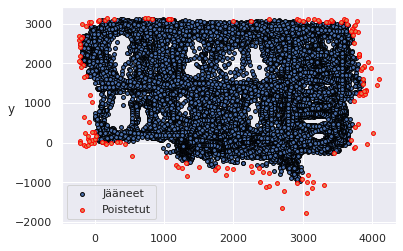

node numero 1 valmis
CPU times: user 7.78 s, sys: 243 ms, total: 8.03 s
Wall time: 6.59 s


node_id               timestamp     x    y    z  q  dayofweek
0        1 2020-06-24 15:20:08.533  2762 -257  100  0          2
1        1 2020-06-24 15:20:08.620  2870 -344  100  0          2
2        1 2020-06-24 15:20:09.623  2916 -344  100  0          2
3        1 2020-06-24 15:20:09.623  2894 -254  100  0          2
4        1 2020-06-24 15:20:10.116  2888 -188  100  0          2

In [7]:
%%time
for i in range(len(df1.node_id.unique())):
    df1 = isolation_forest(df1, 0, .003, i+1)
    print('node numero', i+1, 'valmis')
    
    if i == 0:
        df1.to_csv('./temp_data.csv', index=False)
    else:
        df1.to_csv('./temp_data.csv',mode='a', header=False, index=False)
        
'''df2 = pd.read_csv('./temp_data.csv')
import os
os.remove("./temp_data.csv")
df2.head()'''
df1.head()

# Adding xy_grid values to dataframe (50x50)

In [8]:
%%time
grid_size = 50
df1 = xy_to_grid(df1, df1.x, df1.y, grid_size)
print(df1)

       node_id               timestamp     x    y    z  q  dayofweek  x_grid  \
0            1 2020-06-24 15:20:08.533  2762 -257  100  0          2      36   
1            1 2020-06-24 15:20:08.620  2870 -344  100  0          2      37   
2            1 2020-06-24 15:20:09.623  2916 -344  100  0          2      38   
3            1 2020-06-24 15:20:09.623  2894 -254  100  0          2      38   
4            1 2020-06-24 15:20:10.116  2888 -188  100  0          2      38   
...        ...                     ...   ...  ...  ... ..        ...     ...   
49697        1 2020-07-07 16:36:08.795  1277  -71  100  0          1      18   
49698        1 2020-07-07 16:36:18.795  1278  -77  100  0          1      18   
49699        1 2020-07-07 16:36:27.795  1277  -80  100  0          1      18   
49700        1 2020-07-07 16:36:38.793  1273  -85  100  0          1      18   
49701        1 2020-07-07 16:36:47.793  1272  -86  100  0          1      18   

       y_grid  grid_id  
0           8 

# Write cleaned and diskretized dataframe to mariadb database

In [9]:
%%time
write_df_to_mariadb(df1, 'Testi')

Existing table found. Prepairing to Drop Table named Testi...


Continue? yes/no:  no


Aborting...
CPU times: user 943 µs, sys: 4.05 ms, total: 4.99 ms
Wall time: 3.17 s


# Find and draw exits

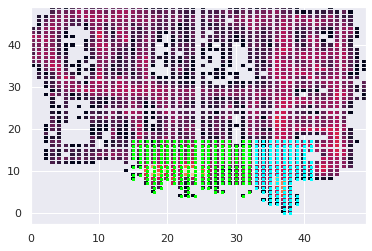

CPU times: user 1.77 s, sys: 135 ms, total: 1.91 s
Wall time: 491 ms


In [10]:
%%time
in_x, in_y = sisään(df1, 'x_grid', 'y_grid')
out_x, out_y = ulos(df1, 'x_grid', 'y_grid')

draw_exits(df1, in_x, in_y, out_x, out_y, 'x_grid', 'y_grid')

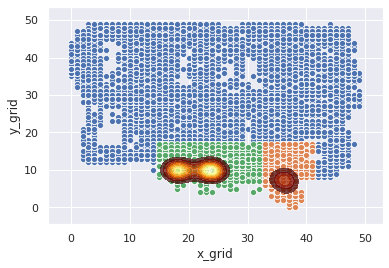

CPU times: user 29.5 s, sys: 212 ms, total: 29.7 s
Wall time: 27.5 s


In [11]:
%%time
# Muokataan sisäänkäynnin ja kassojen sijainnit ID-muotoon.
grid_size = 50
in_ID = xy_to_ID(in_x,in_y, grid_size)
out_ID = xy_to_ID(out_x,out_y, grid_size)

# Voidaan tarkistaa sijaintien oikeellisuus
sns.scatterplot(x="x_grid", y="y_grid", data = df1)
sns.scatterplot(x=in_x, y=in_y)
sns.scatterplot(x=out_x, y=out_y)
hmax= sns.kdeplot(df1.x_grid, df1.y_grid, cmap="afmhot", shade=True, alpha = 0.7)
hmax.collections[3].set_alpha(0)
plt.show()

### Erotetaan kauppareissut toisistaan

In [13]:
%%time
# Haetaan uniikit id:t
u_in_ID = in_ID.unique()
u_out_ID = out_ID.unique()

reitit = erottele_reitit(df1, u_in_ID, u_out_ID)

reitit = poista_lyhyet_reitit(reitit, grid_size)
df_reitit = reitit_dataframeksi(reitit)

CPU times: user 318 ms, sys: 3.86 ms, total: 322 ms
Wall time: 321 ms


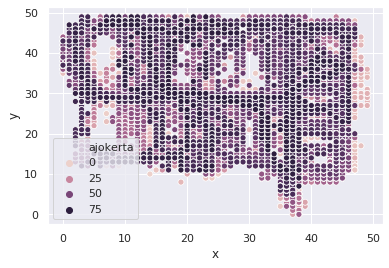

CPU times: user 3.39 s, sys: 87.7 ms, total: 3.48 s
Wall time: 2.06 s


In [14]:
%%time
# Plotataan kaikki erotellut kauppareissut yhdessä
plot_all_routes(df_reitit, grid_size)

# Poistetaan liiat nopeudet

Uusi taulu:  25595
Poistettuja pisteitä:  66


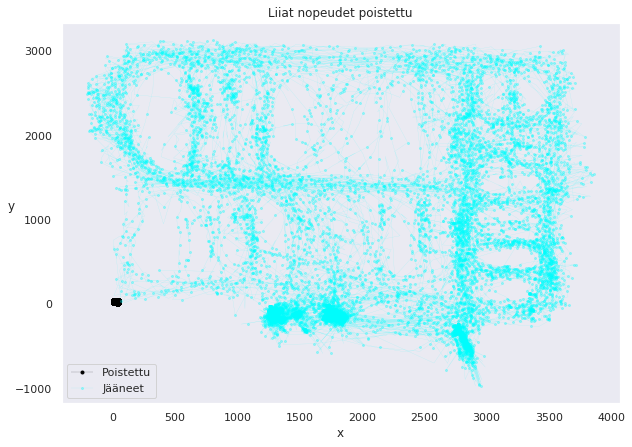

CPU times: user 31.7 s, sys: 16 ms, total: 31.7 s
Wall time: 31.7 s


In [15]:
%%time
# Otetaan kopio taulusta piirtämistä varten
dftest = df1.copy()
# Laskee x:n ja y:n oudot nopeudet
uusi_df = velocity.column_vel(df_reitit, 'x', 'y')
# Piirtää kuvan näistä
velocity.draw_vel(df_reitit, df1, 'x', 'y')

Ajokerrat:  71


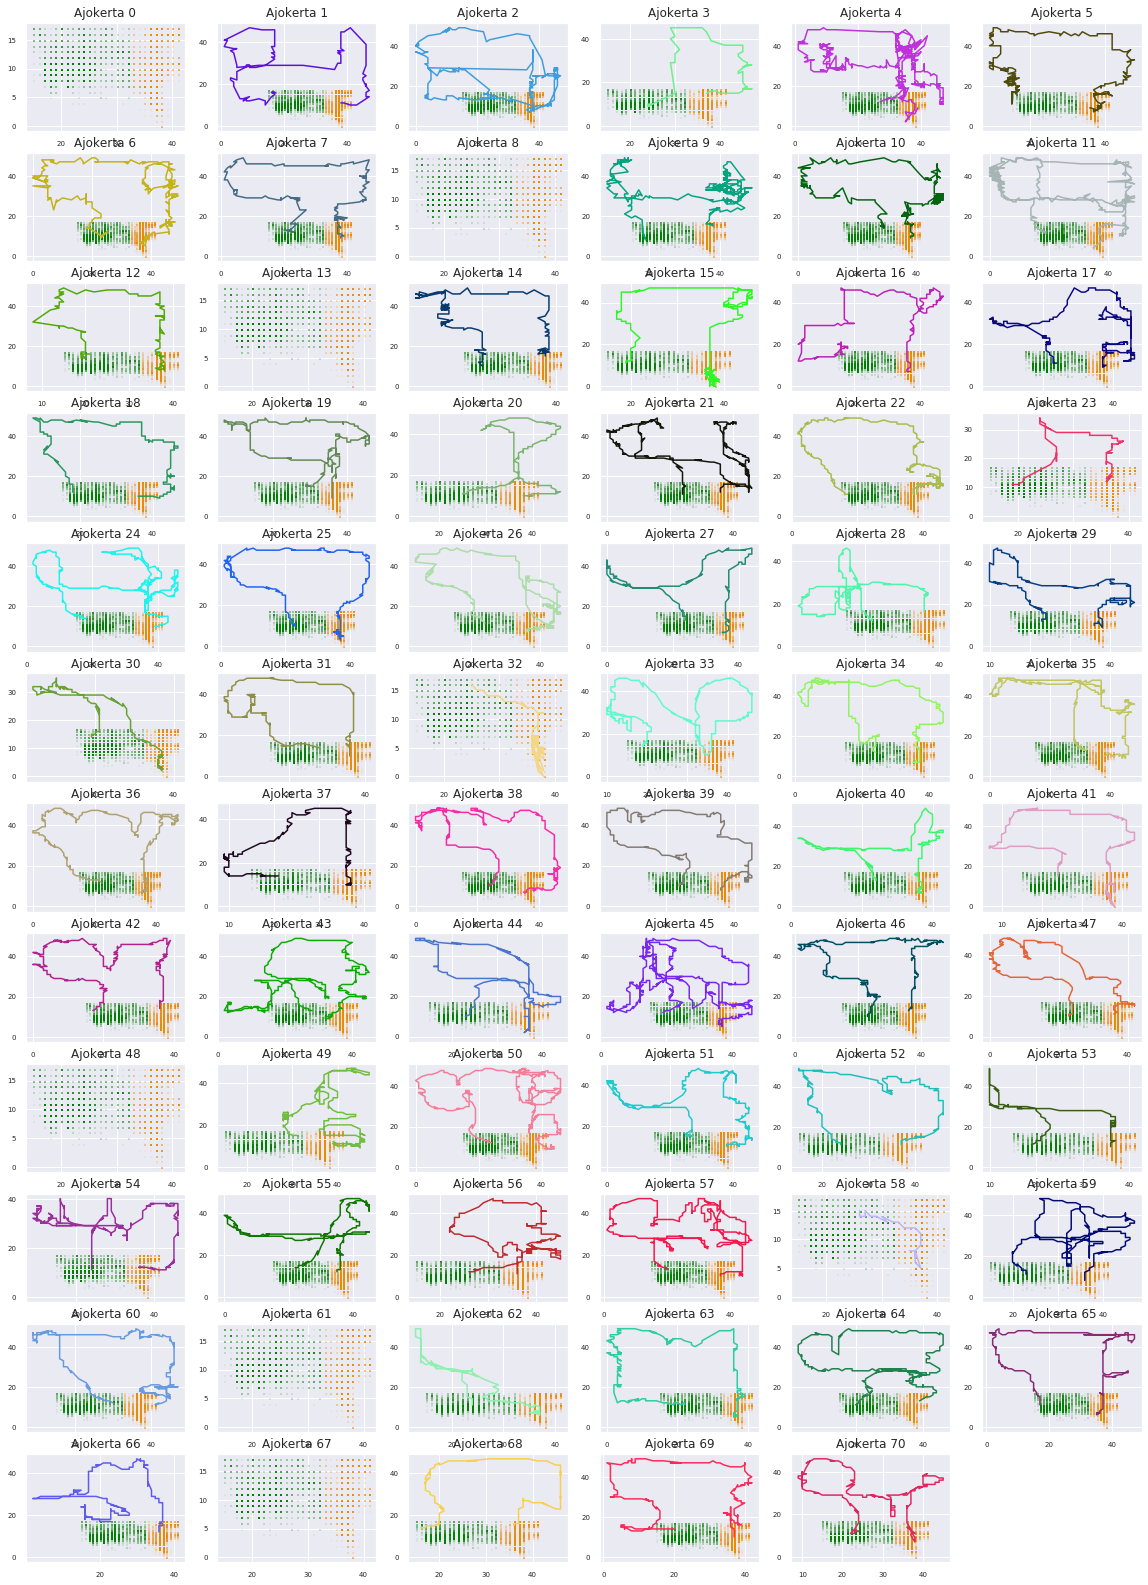

CPU times: user 57.7 s, sys: 2.84 s, total: 1min
Wall time: 21 s


In [96]:
%%time

import matplotlib.colors as pltc
from random import sample
import matplotlib.animation as animation

ajot = df_reitit["ajokerta"].unique()
ajot_len = max(df_reitit["ajokerta"].unique())

#c = cm.flag(np.linspace(0, 1, ajot_len))
all_colors = [k for k,v in pltc.cnames.items()]

print("Ajokerrat: ",ajot_len)
plt.figure(figsize=(20,(ajot_len/2))) # specifying the overall picture size


for i in range(ajot_len):
    c = sample(all_colors, ajot_len)
    plt.subplot((ajot_len/5)+1,6,i+1)
    plt.plot(df_reitit[df_reitit["ajokerta"] == i]['x'], df_reitit[df_reitit["ajokerta"] == i]['y'], color=np.random.random(3))#np.random.random(3)
    plt.scatter(in_x, in_y, color='darkorange', marker='s', s=1, alpha=0.05)
    plt.scatter(out_x, out_y, color='green', marker='s', s=1,  alpha=0.05)
    plt.title(f"Ajokerta {i}")
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    #plt.axis('off')

plt.show()

112


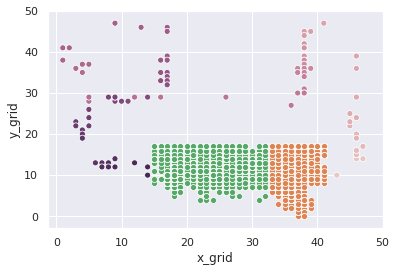

320


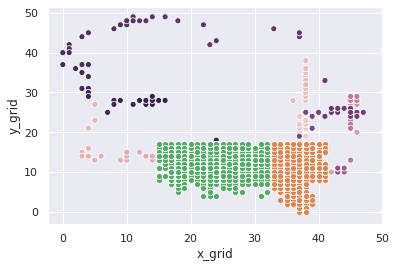

72


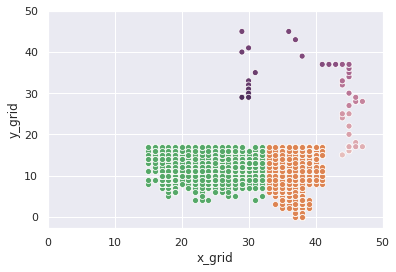

569


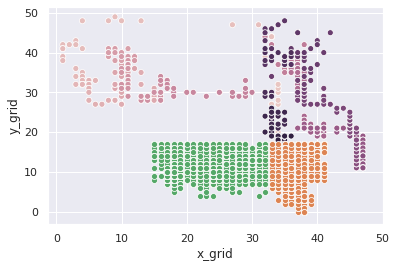

280


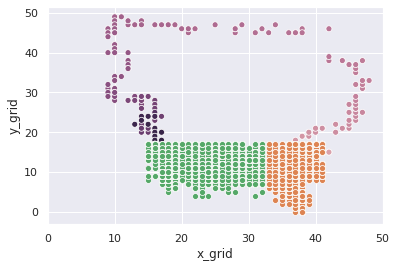

340


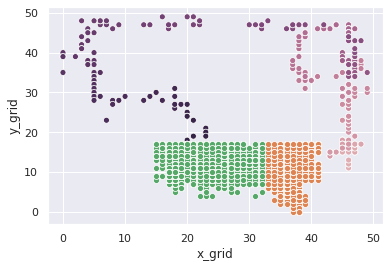

191


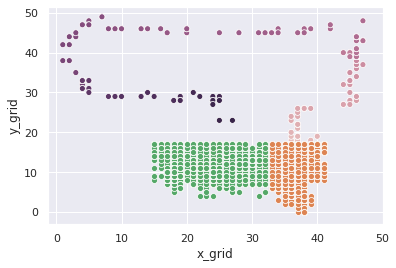

426


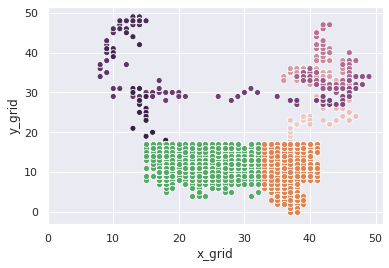

238


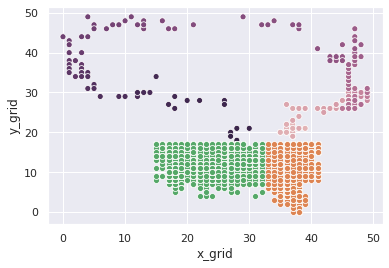

383


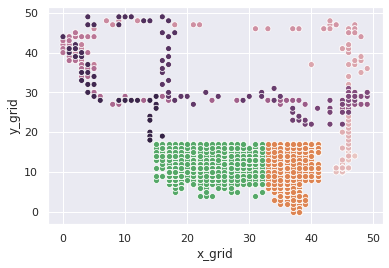

137


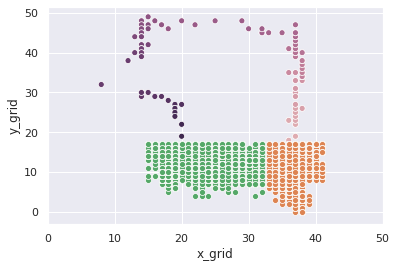

198


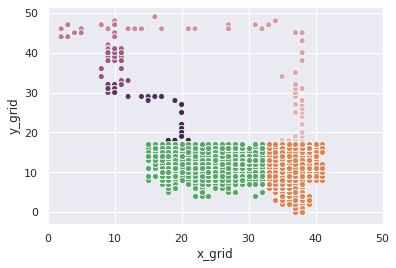

599


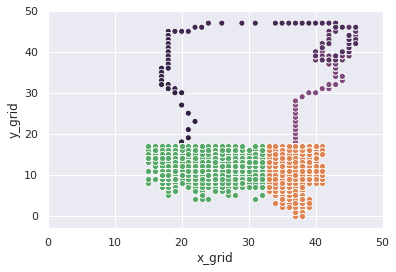

329


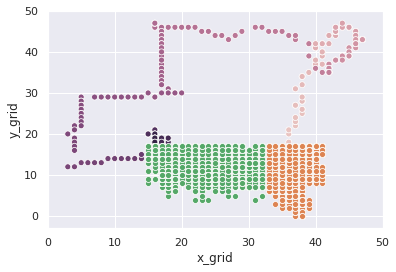

642


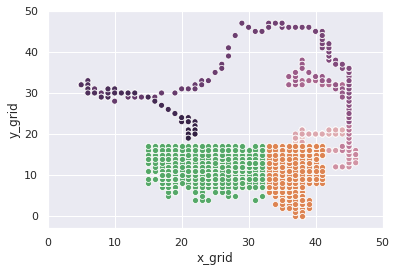

374


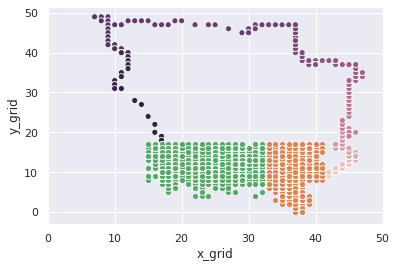

380


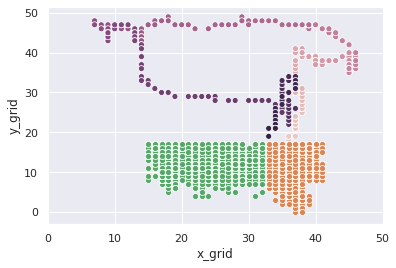

198


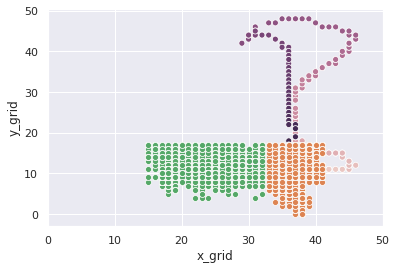

469


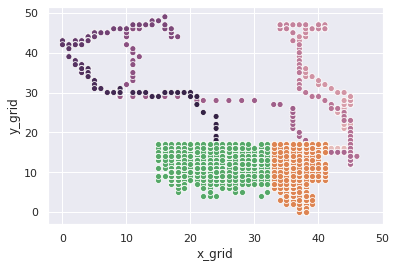

582


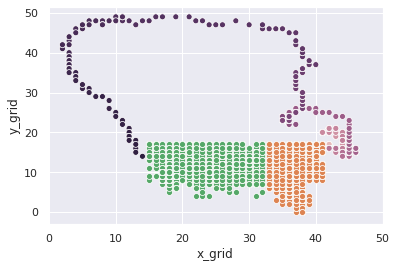

87


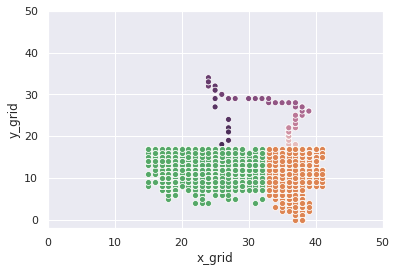

452


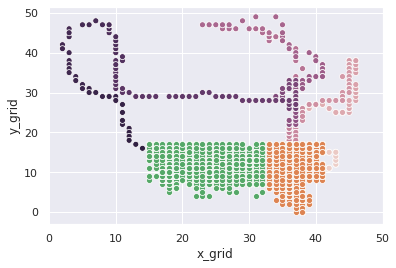

421


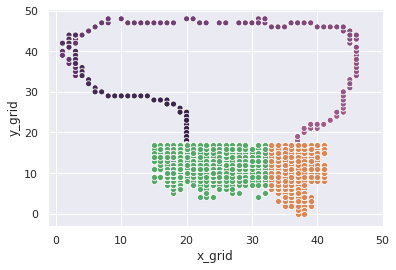

311


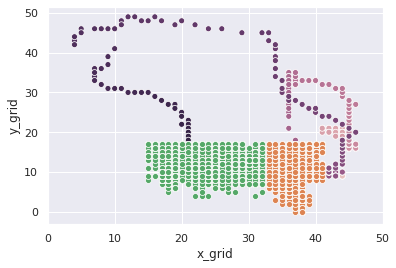

219


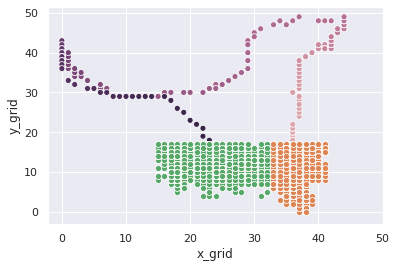

282


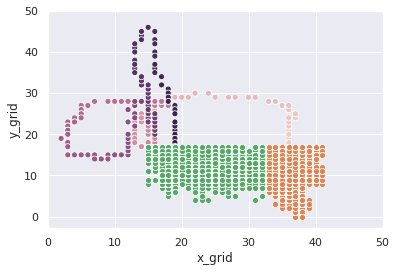

286


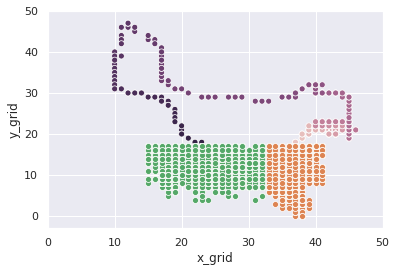

245


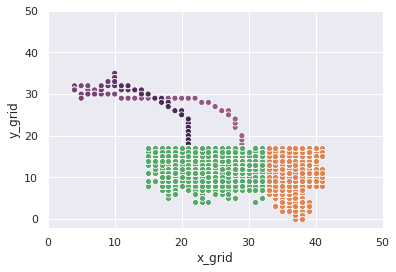

242


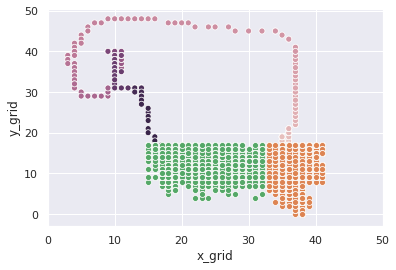

1282


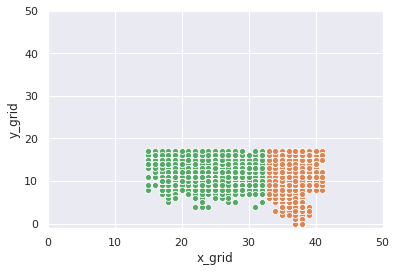

266


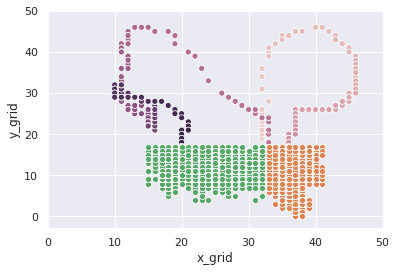

1959


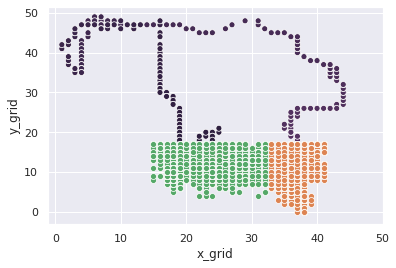

407


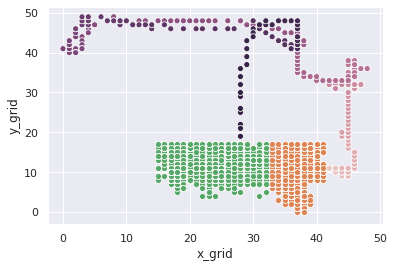

386


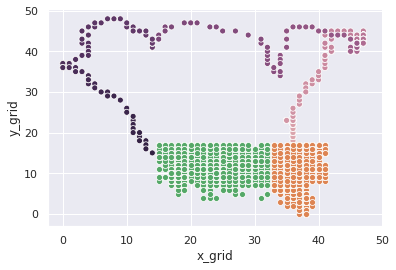

225


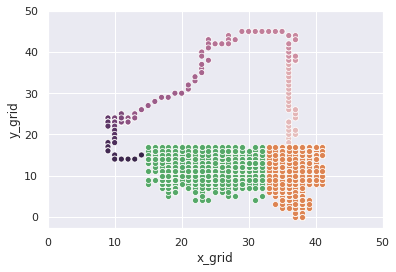

416


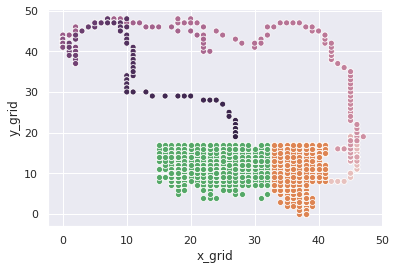

412


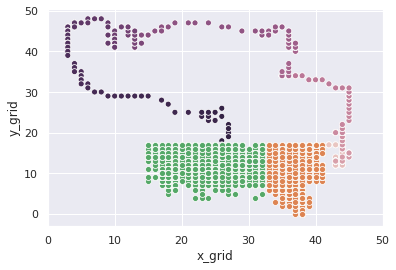

305


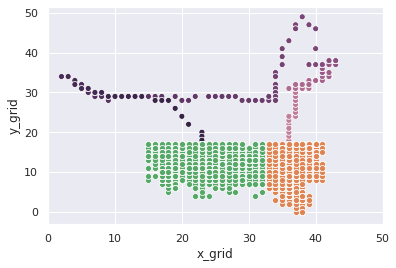

414


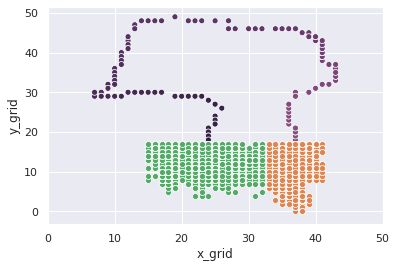

349


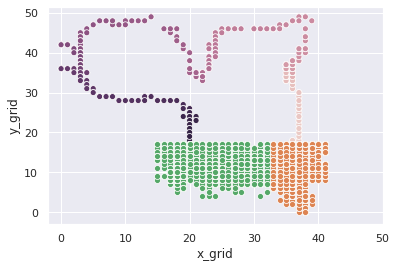

488


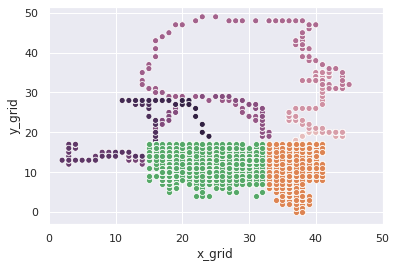

242


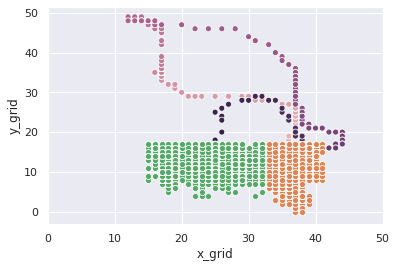

897


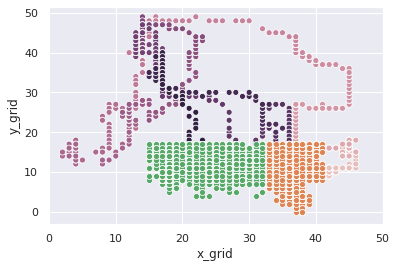

408


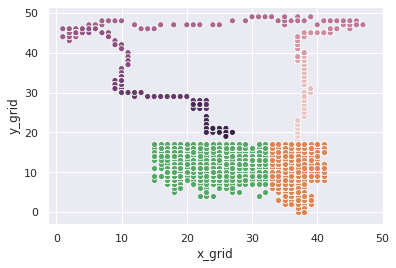

268


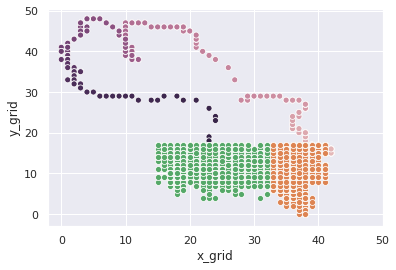

445


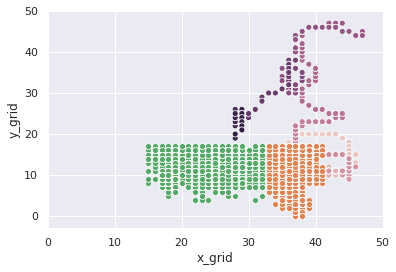

716


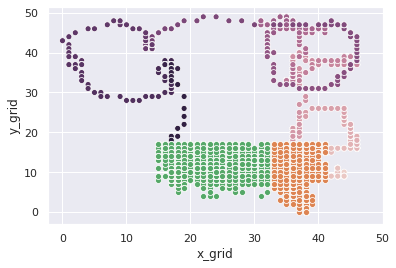

421


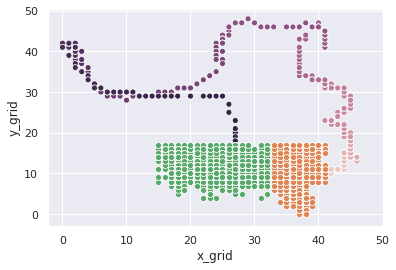

181


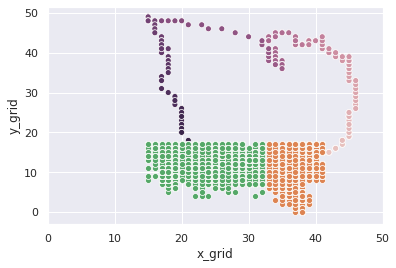

190


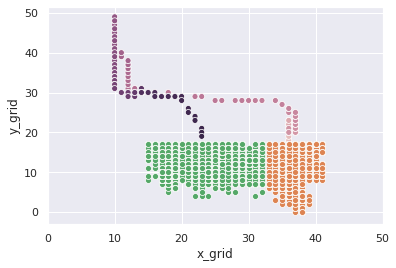

454


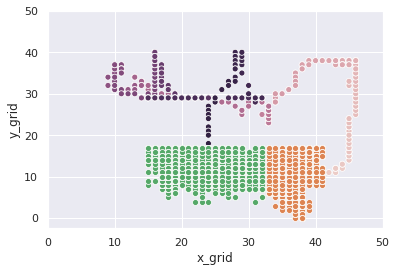

297


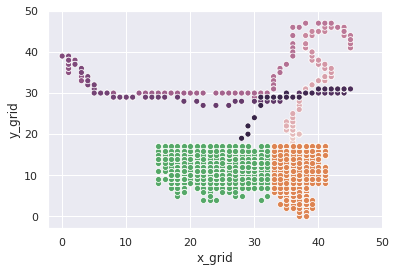

392


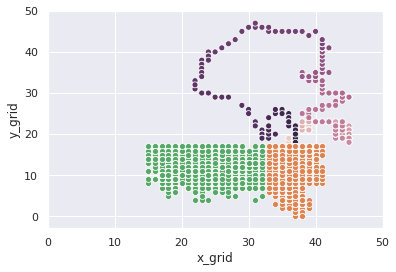

584


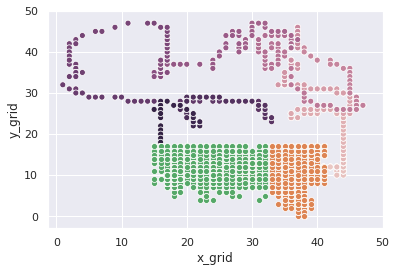

211


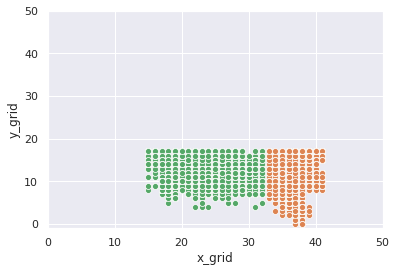

449


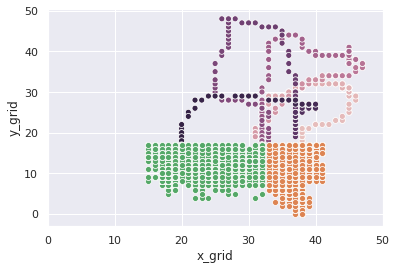

397


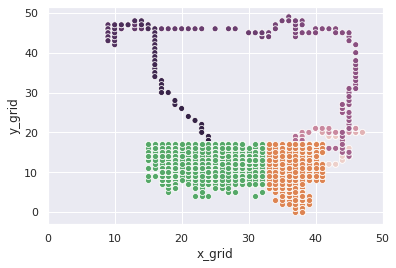

410


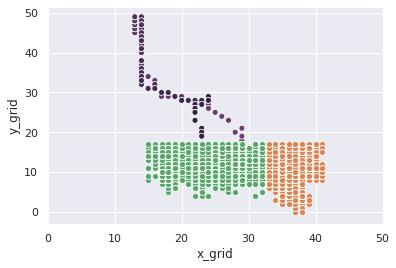

311


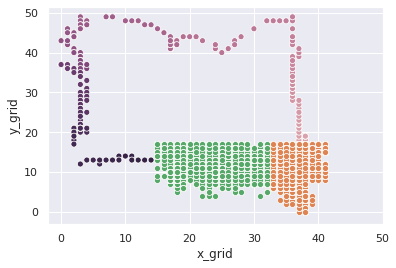

404


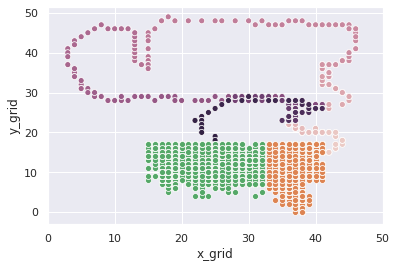

394


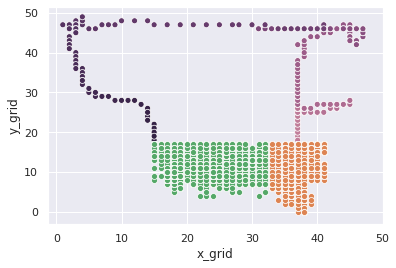

404


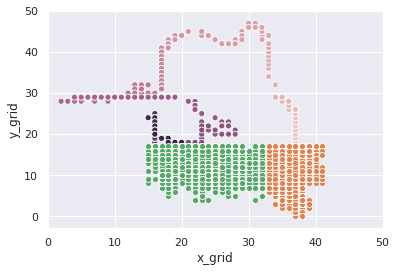

117


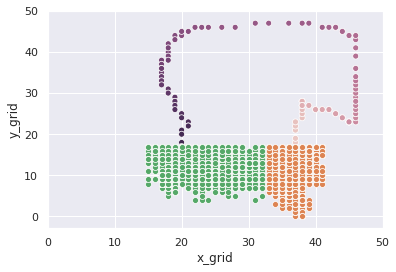

318


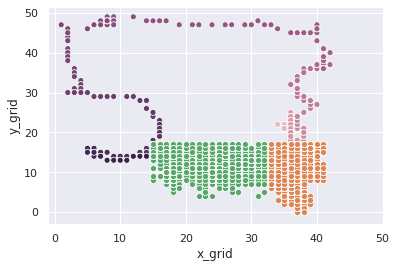

256


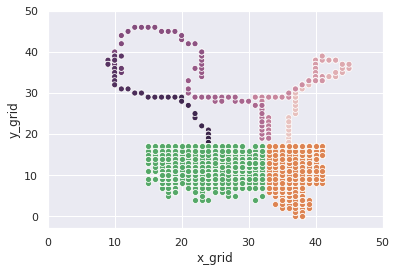

136


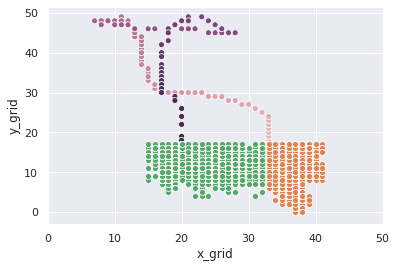

CPU times: user 3min 8s, sys: 11.1 s, total: 3min 19s
Wall time: 44.1 s


In [66]:
%%time
# Plottaa jokaisen kauppareissut erikseen.
plot_unique_routes(df_reitit, grid_size, in_x, in_y, out_x, out_y)   
# Ensimmäisissä on aika paljon häiriötä